# CSE 152 : Introduction to Computer Vision, Spring 2018 – Assignment 3

## Problem 1: Binarization [10 points]

This Otsu's algorithm automatically determine an intensity level to threshold an image to segment out the foreground from the background. The output of your function is a binary image that is black (pixel values = 0) for all background pixels and white (pixel values = 1) for all foreground pixels. 

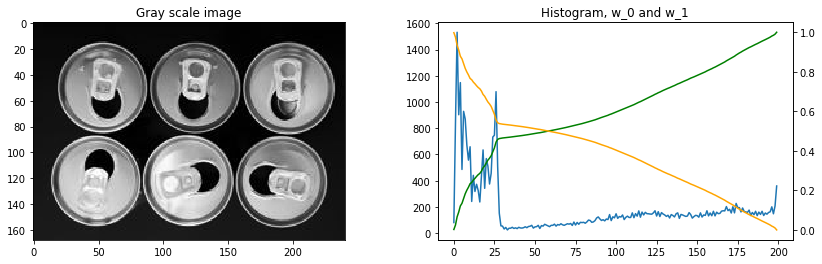

In [60]:
import cv2
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from imageio import imread

def H(img_gray, bin_num=256):
    hist, bin_edges = np.histogram(img_gray, bins=np.arange(bin_num+1))
    bins = bin_edges[:-1]

    p = np.histogram(img_gray, bins=np.arange(bin_num+1), density=True)[0]
    w_0 = p.cumsum();
    w_1 = 1 - w_0
    
    return (hist, bins, p, w_0, w_1)

plt.gcf().set_size_inches(14,4)

plt.subplot(1,2,1)
img_gray = cv2.imread('can_pix.png',0)
plt.imshow(img_gray,cmap='gray')
plt.title('Gray scale image')

plt.subplot(1,2,2)
img_gray = cv2.GaussianBlur(img_gray,(3,3),0)
bin_num = 200
hist, bins, p, w_0, w_1 = H(img_gray, bin_num)
plt.plot(hist)
plt.title('Histogram, w_0 and w_1')
plt.twinx().plot(w_0,'g')
plt.plot(w_1,'orange')

plt.show()

Apply Otsu's method:

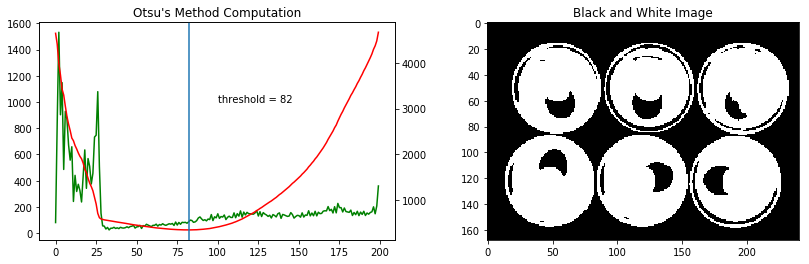

In [61]:
def V(p, bins, w_0, w_1, bin_num = 256):
    v = np.empty(hist.shape)
    for t in range(bin_num):
        m_0 = np.divide(np.sum(p[:t+1] * bins[:t+1]), w_0[t], where=w_0[t]!=0)
        m_1 = np.divide(np.sum(p[t+1:] * bins[t+1:]), w_1[t], where=w_1[t]!=0)
        v_0 = np.sum(((bins[:t+1] - m_0)**2) * p[:t+1])
        v_1 = np.sum(((bins[t+1:] - m_1)**2) * p[t+1:])
        v[t] = w_0[t] * v_0 + w_1[t] * v_1
    return v

def otsu(grey_img, threshold=None):
    binary_img = np.copy(grey_img)
    
    if threshold is None:
        hist, bins, p, w_0, w_1 = H(grey_img)
        v = V(p, bins, w_0, w_1)
        threshold = np.argmin(v)
    
    for i in range(binary_img.shape[0]):
        for j in range(binary_img.shape[1]):
            if binary_img[i][j] < threshold:
                binary_img[i][j] = 0
            else:
                binary_img[i][j] = 1

    return binary_img

plt.gcf().set_size_inches(14,4)

plt.subplot(1,2,1)
plt.title('Otsu\'s Method Computation')
v = V(p, bins, w_0, w_1, bin_num)
img_bw = otsu(img_gray, np.argmin(v))
plt.plot(hist,'g')
plt.text(100,1000,'threshold = {}'.format(np.argmin(v)))
plt.gca().twinx().plot(v,'r-')
plt.axvline(x=np.argmin(v))


plt.subplot(1,2,2)
plt.title('Black and White Image')
plt.imshow(img_bw, cmap='gray')

plt.show()

## Problem 2: Connected Components [40 points]

$\textbf{2.1 Connected Regions [15 pts]}$

(a) Implement a connected component labeling algorithm, assuming 8-connectedness. The function takes as input a binary image and output a 2D matrix of the same size where each connected region is marked with a distinct positive number (e.g. 1, 2, 3). 

In [62]:
# use union-find algorithm to optimize the expensive ecursive calls

def connected_component(grey_img):
    linked = {}
    labels = np.copy(grey_img)
    NextLabel = 1

    def find(x):
        if x!=linked[x]:
            linked[x]=find(linked[x]);
        return linked[x];

    def union(x, y):
        a=find(x)
        b=find(y)
        if a!=b:
            linked[b]=a;

    for i, row in enumerate(labels):
        for j, item in enumerate(row):
            if item != 0:
                # find neighbors
                neighbors = []
                if j-1>=0 and labels[i,j-1] != 0: 
                    neighbors.append((i,j-1))
                if i-1>=0 and j-1>=0 and labels[i-1,j-1] != 0: 
                    neighbors.append((i-1,j-1))
                if i-1>=0 and labels[i-1,j] != 0: 
                    neighbors.append((i-1,j))
                if i-1>=0 and j+1 < labels.shape[1] and labels[i-1,j+1] != 0: 
                    neighbors.append((i-1,j+1))
                # label
                if not neighbors:
                    linked[NextLabel] = NextLabel
                    labels[i,j] = NextLabel
                    NextLabel += 1
                else:
                    SmallestNeighbor = labels[neighbors[0]]
                    for neighbor in neighbors:
                        if labels[neighbor] < SmallestNeighbor:
                            SmallestNeighbor = labels[neighbor]
                    labels[i,j] = find(SmallestNeighbor)
                    for neighbor in neighbors:
                        union(SmallestNeighbor, labels[neighbor])
    
    # use distinct label numbers
    for i, row in enumerate(labels):
        for j, item in enumerate(row):
            if labels[i,j]:
                labels[i,j] = find(labels[i,j])
    
    # makes the labels sequential
    label_order = list(set(linked.values()))
    label_order.sort()
    for key, value in linked.items():
        linked[key] = label_order.index(value) + 1
    for i, row in enumerate(labels):
        for j, item in enumerate(row):
            if item != 0:
                labels[i,j] = linked[labels[i,j]]

    return labels

On the image can pix.png, display an image of detected connected components where connected region is mapped to a distinct color using imshow.

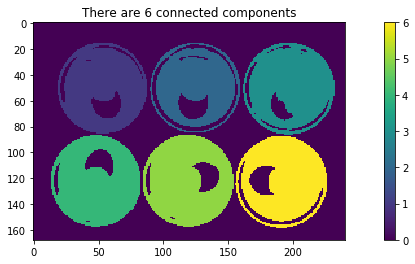

In [63]:
c = connected_component(img_bw)
plt.gcf().set_size_inches(14,4)
plt.title('There are {} connected components'.format(np.max(c)))
plt.imshow(c)
plt.colorbar()

(b) How many components are in the image coins pix.jpg? What does your connected component algorithm give as output for this image? 

I expected **2 components**. Because most of the coins are connected together. There's only one on the bottom left cover that does not touch the others, which should be a separate component. The output is exactly 2 connected components:

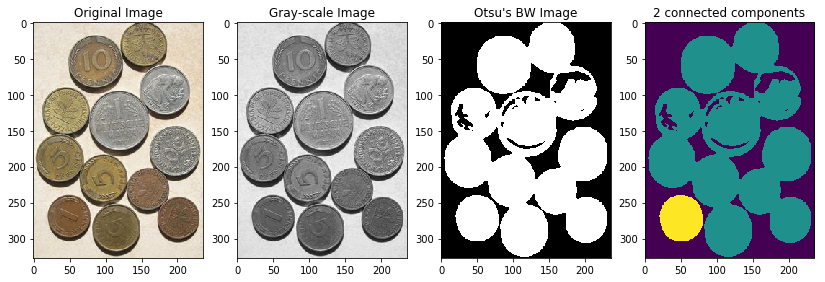

In [111]:
plt.gcf().set_size_inches(14,5)

plt.subplot(1,4,1)
img_coin = imread('coins_pix.jpg')
plt.title('Original Image')
plt.imshow(img_coin)

plt.subplot(1,4,2)
plt.title('Gray-scale Image')
img_coin_gray = cv2.imread('coins_pix.jpg',0)
plt.imshow(img_coin_gray,cmap='gray')

plt.subplot(1,4,3)
plt.title('Otsu\'s BW Image')
img_coin_gray_blur = cv2.GaussianBlur(img_coin_gray,(11,11),0)
hist, bins, p, w_0, w_1 = H(img_coin_gray_blur)
v = V(p, bins, w_0, w_1)
img_coin_bw = otsu(img_coin_gray_blur, np.argmin(v))
img_coin_bw_r = 1-img_coin_bw
plt.imshow(img_coin_bw_r,cmap='gray')

plt.subplot(1,4,4)
c = connected_component(img_coin_bw_r)
plt.title('{} connected components'.format(np.max(c)))
plt.imshow(c)

$\textbf{2.2 Take your own images [5 pts]}$

Take 3 pictures with their objects clearly distinguishable from the background. See Figure 1. 

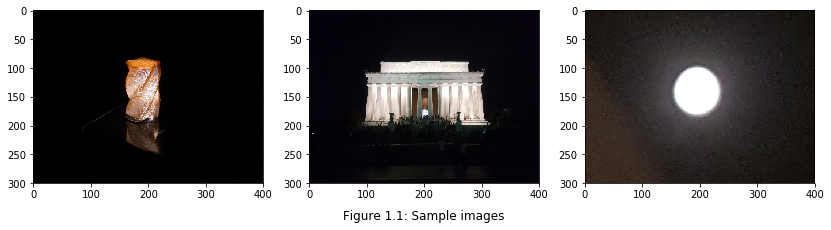

In [180]:
from skimage.transform import resize

plt.gcf().set_size_inches(14,4)

# my 3d-printed object
plt.subplot(131)
pic1_original = resize(imread('0.jpeg'), (300,400), mode='reflect')
plt.imshow(pic1_original)
pic1 = cv2.GaussianBlur(pic1_original,(5,5),0)

# Lincoln Memorial I took in D.C.
plt.subplot(132)
pic2_original = resize(imread('1.jpg'), (300,400), mode='reflect')
plt.imshow(pic2_original)
pic2 = cv2.GaussianBlur(pic2_original,(11,11),0)
plt.title('Figure 1.1: Sample images', y = -0.25)

# photo of the moon taken by phone
plt.subplot(133)
pic3_original = resize(imread('2.jpg')[230:800, 100:-20], (300,400), mode='reflect')
plt.imshow(pic3_original)
pic3 = cv2.GaussianBlur(pic3_original,(11,11),0)

In addition, show similar output images as in Problem 2.1.

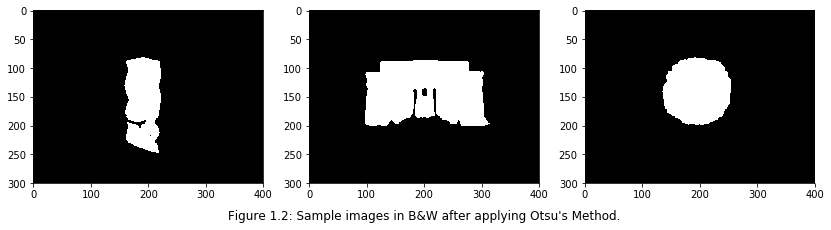

In [181]:
pic1_bw = otsu(np.dot(pic1, [0.299*255, 0.587*255, 0.114*255]).astype(int))
pic2_bw = otsu(np.dot(pic2, [0.299*255, 0.587*255, 0.114*255]).astype(int))
pic3_bw = otsu(np.dot(pic3, [0.299*255, 0.587*255, 0.114*255]).astype(int))

plt.gcf().set_size_inches(14,4)
plt.subplot(131)
plt.imshow(pic1_bw, cmap='gray')
plt.subplot(132)
plt.imshow(pic2_bw, cmap='gray')
plt.title('Figure 1.2: Sample images in B&W after applying Otsu\'s Method.', y = -0.25)
plt.subplot(133)
plt.imshow(pic3_bw, cmap='gray')

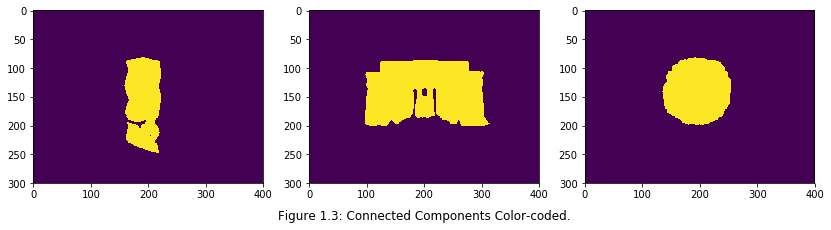

In [182]:
pic1_cc = connected_component(pic1_bw)
pic2_cc = connected_component(pic2_bw)
pic3_cc = connected_component(pic3_bw)

plt.gcf().set_size_inches(14,4)
plt.subplot(131)
plt.imshow(pic1_cc)
plt.subplot(132)
plt.imshow(pic2_cc)
plt.title('Figure 1.3: Connected Components Color-coded.', y = -0.25)
plt.subplot(133)
plt.imshow(pic3_cc)

$\textbf{2.3 Image moments and rectification [10 pts]}$

Write three functions which compute the moments, central moments, and normalized moments of a marked region. Each function should take as input a 2D matrix (output of part 2.2) and 3 numbers $j$, $k$, and $d$. The output should be the $(j, k)$ moment $M_{j,k}$, central moment $\mu_{j,k}$, normalized moment $m_{j,k}$ of the region marked with positive number $d$ in the input matrix.

In [183]:
def moment(img_cc,j,k,d):
    M_jk = 0
    for x in range(img_cc.shape[0]):
        for y in range(img_cc.shape[1]):
            if img_cc[x,y] == d:
                M_jk += x**j * y**k
    return M_jk

def central_moment(img_cc,j,k,d):
    mu_jk = 0
    (x0,y0) = centroid(img_cc,d)
    for x in range(img_cc.shape[0]):
        for y in range(img_cc.shape[1]):
            if img_cc[x,y] == d:
                mu_jk += (x-x0)**j*(y-y0)**k
    return mu_jk

def norm_moment(img_cc,j,k,d):
    m_jk = 0
    m00 = moment(0,0,d)
    u20 = central_moment(img_cc,2,0,d)
    u02 = central_moment(img_cc,0,2,d)
    ox = math.sqrt(u20/m00)
    oy = math.sqrt(u02/m00)
    (x0,y0) = centroid(d)
    for x in range(img_cc.shape[0]):
        for y in range(img_cc.shape[1]):
            if img_cc[x,y] == d:
                m_jk += ((x-x0)/ox)**j*((y-y0)/oy)**k
    return m_jk

def centroid(img_cc,d):
    M00 = moment(img_cc,0,0,d)
    M01 = moment(img_cc,0,1,d)
    M10 = moment(img_cc,1,0,d)
    return M10/M00,M01/M00

Using these functions, on each of the three images, draw the centroid of each object. Also
compute the eigenvectors of the centralized second moment matrix and draw the two eigenvectors
on the centroid. This should indicate the orientation of each object.

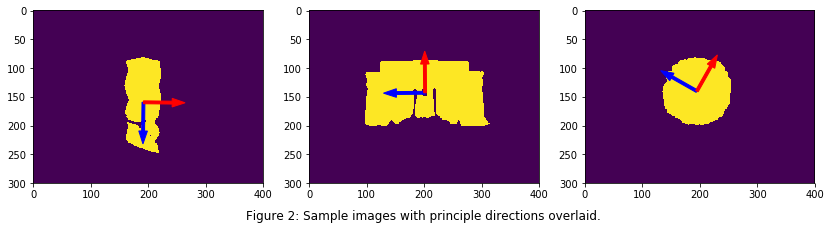

In [184]:
def centralized_2nd_moment_matrix(img_cc,d):
    u20 = central_moment(img_cc,2,0,d)
    u11 = central_moment(img_cc,1,1,d)
    u02 = central_moment(img_cc,0,2,d)
    M = np.matrix([[u20,u11],[u11,u02]])
    return M

def major_evec(cc_img,d):
    (w,evec)= np.linalg.eig(centralized_2nd_moment_matrix(cc_img,d))
    # blue horizontal large
    v0 = evec[0]
    # red vertical small
    v1 = evec[1]
    if w[1] > w[0]:
        v0 = evec[1]
        v1 = evec[0]
    return (v0, v1)

def plot_img_moments(cc_img,d):
    (x0,y0) = centroid(cc_img,d)
    v0, v1 = major_evec(cc_img,d);
    plt.imshow(cc_img)
    plt.arrow(y0,x0,50*v0[0,1],50*v0[0,0],width=5,color='b')
    plt.arrow(y0,x0,50*v1[0,1],50*v1[0,0],width=5,color='r')

plt.gcf().set_size_inches(14,4)
plt.subplot(131)
plot_img_moments(pic1_cc,1)
plt.subplot(132)
plot_img_moments(pic2_cc,1)
plt.title('Figure 2: Sample images with principle directions overlaid.', y = -0.25)
plt.subplot(133)
plot_img_moments(pic3_cc,1)

$\textbf{2.4 Image alignment [10 pts]}$

We have seen that the orientation computed from Problem 2.3 can be used to roughly align the orientation of the region (i.e. in-plane rotation). Write a function to rotate the region around its centroid so that the eigenvector corresponding to the largest eigenvalue will be horizontal (aligned with $[1, 0]^T$). 

The function takes as input a 2D matrix (output of Problem 2.1) and output a matrix of the same size in which all marked regions are aligned. Turn in the aligned outputs for your images.
Note: After finding the rotation matrix R to rotate the largest eigenvector to $[1, 0]^T$ , we rotate all points $(x, y)$ belonging to that region using the following transformation

\begin{eqnarray}
\begin{bmatrix}x'\\y'
\end{bmatrix}=R\begin{bmatrix}x-\hat{x}\\y-\hat{y}
\end{bmatrix}+\begin{bmatrix}\hat{x}\\\hat{y}
\end{bmatrix}
\end{eqnarray}


where $[\hat{x}, \hat{y}]^T$
T are the centroid coordinates of the region. For simplicity, just ignore the cases when
part of the aligned region falls outside of the image border or is overlapped with other regions. You
can avoid these issues when capturing your images (e.g. put your objects a bit far apart). Finally,
note that the rotation matrix can be created trivially from the eigenvectors.

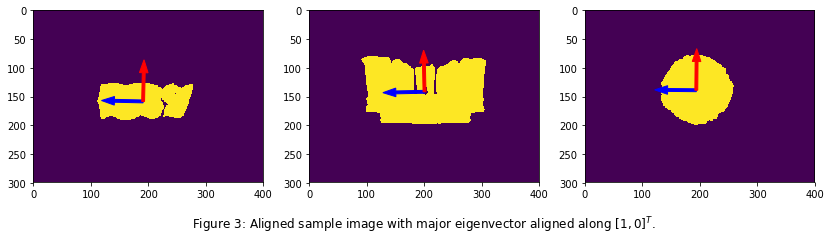

In [185]:
def R(v):
    c = np.dot(v,np.array([0,1]))
    s = math.sin(math.acos(c))
    return np.array([[c,-s],[s,c]])

def rotate_region(cc_img, d):
    aligned_img = np.zeros(cc_img.shape)
    (x0,y0) = centroid(cc_img,d)
    v0, v1 = major_evec(cc_img,d);
    for i in range(cc_img.shape[0]):
        for j in range(cc_img.shape[1]):
            if cc_img[i,j]==d:
                T = (np.dot(R(v0),np.array([[i-x0],[j-y0]]))
                         + np.array([[x0],[y0]])).astype(int)
                x = round(T[0][0])
                y = round(T[1][0])
                if x < cc_img.shape[0] - 1 and x > 0 and y < cc_img.shape[1] - 1 and y > 0:
                    aligned_img[x,y] = 1
                    aligned_img[x-1,y] = 1
                    aligned_img[x,y-1] = 1
                    aligned_img[x-1,y-1] = 1
    return aligned_img

plt.gcf().set_size_inches(14,4)
plt.subplot(131)
plot_img_moments(rotate_region(pic1_cc,1),1)
plt.subplot(132)
plot_img_moments(rotate_region(pic2_cc,1),1)
plt.title('Figure 3: Aligned sample image with major eigenvector aligned along $[1, 0]^T$.', y = -0.3)
plt.subplot(133)
plot_img_moments(rotate_region(pic3_cc,1),1)

## Problem 3: Filtering [15 points]

In this problem we will play with convolution filters. Filters, when convolved with an image, will respond strongest on locations of an image that look like the filter when it is rotated by 180 degrees. This allows us to use filters as object templates in order to identify specific objects within an image. In the case of this assignment, we will be finding cars within an image by convolving a car template onto that image.

$\textbf{3.1 Warmup - Mickey Detection [5 pts]}$

First convolve a filter to a synthetic image. The filter or template is filter.jpg and the synthetic image is toy.png. 

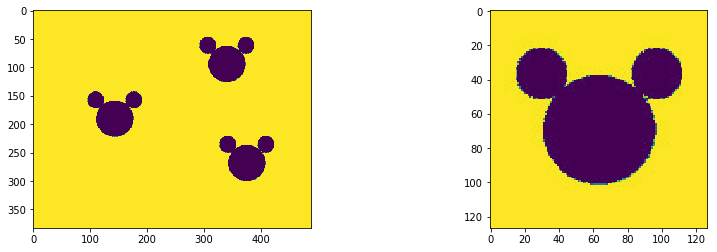

In [12]:
toy = imread('toy.png')
toy_filter = imread('filter.jpg')

plt.gcf().set_size_inches(14,4)

plt.subplot(1,2,1)
plt.imshow(toy)

plt.subplot(1,2,2)
plt.imshow(toy_filter)

First modify the filter image and original slightly. We will do so by subtracting the mean of the image intensities from the image i.e. $I_t \rightarrow I - means(\textbf{vec}(I))$, where $I_t$ is the transformed image and $I$ is
the original image. 

In [13]:
toy_t = toy - np.mean(toy)
toy_filter_t = toy_filter - np.mean(toy_filter)

In the original image (not the image with its mean subtracted), draw a bounding box of the same size as the filter image around the top 3 intensity value locations in the convolved image. 

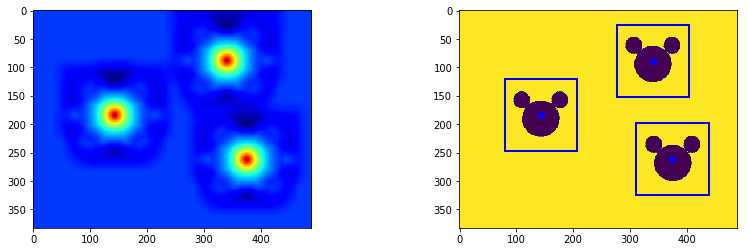

In [113]:
import matplotlib.patches as patches
# from collections import namedtuple
# from matplotlib.transforms import Bbox

def to_regular_rect_coordinates(center_point, sizeref): # in camera imshow axes
    x, y = center_point
    x_length = sizeref[0]
    y_length = sizeref[1]
    x_0 = x - x_length / 2
    y_0 = y - y_length / 2
    return (y_0,x_0),y_length,x_length

def plot_bounding_box(center_point, sizeref=toy_filter.shape, color='b', hide_center = False):
    if not hide_center:
        y, x = center_point # image coordinates
        plt.plot(x,y,color + 'o')
    xy, xx, yy = to_regular_rect_coordinates(center_point, sizeref)
    rectangle_patch = patches.Rectangle(xy,xx,yy,linewidth=2,edgecolor=color,facecolor='none')
    plt.gca().add_patch(rectangle_patch)

plt.gcf().set_size_inches(14,4)
plt.subplot(1,2,1)
toy_convolve = sp.ndimage.filters.convolve(toy_t,np.rot90(toy_filter_t,2))
plt.imshow(toy_convolve, cmap='jet')

toy_convolve_argmax_flat = np.argsort(toy_convolve, axis=None)[-3:]
p1 = np.unravel_index(toy_convolve_argmax_flat[-1], toy_convolve.shape)
p2 = np.unravel_index(toy_convolve_argmax_flat[-2], toy_convolve.shape)
p3 = np.unravel_index(toy_convolve_argmax_flat[-3], toy_convolve.shape)

plt.subplot(1,2,2)
plt.imshow(toy)
plot_bounding_box(p1)
plot_bounding_box(p2)
plot_bounding_box(p3)

Describe how well you think this technique will work on more realistic images. Do you foresee any problems for this algorithm on more realistic images?

The technique might present challenges if the pattern we are looking for is **complex or transformed**, like roatated, scaled, etc. Image **noise** might also play a factor on accuracy in realistic images. Convolution is also **computation intensive**, it might be challenging to perform it on high resolution images.

$\textbf{3.2 Detection quality [4 pts]}$

We have now created an algorithm that produces a bounding box around a detected object. However, we have no way to know if the bounding box is good or bad. In the example images shown above, the bounding boxes look reasonable, but not perfect. Given a ground truth bounding box (g) and a
predicted bounding box (p), a commonly used measurement for bounding box quality is:

\begin{eqnarray}
r = \frac{p \cap g}{p \cup g}
\end{eqnarray}

More intuitively, this is the number of overlapping pixels between the bounding boxes divided by the total number of unique pixels of the two bounding boxes combined. Assuming that all bounding boxes will be axis-aligned rectangles, implement this error function and try it on the toy example in the previous section. 

In [15]:
def detection_quality(predicted, true = None, true_coordinates = None, receiveIntersection = False):
    (p_x,p_y), p_xx, p_yy = to_regular_rect_coordinates(predicted[0], predicted[1])
    if true is not None:
        (t_x,t_y), t_xx, t_yy = to_regular_rect_coordinates(true[0], true[1])
    elif true_coordinates is not None:
        t_x, t_y, t_xx, t_yy = true_coordinates
    else:
        return 0
    b1 = patches.Rectangle((p_x,p_y), p_xx, p_yy).get_bbox()
    b2 = patches.Rectangle((t_x,t_y), t_xx, t_yy).get_bbox()
    b0 = b1.intersection(b1,b2)
    if b0 is not None:
        b0_area = np.abs(np.prod(b0.size))
    else:
        b0_area = 0
    b1_area = np.abs(np.prod(b1.size))
    b2_area = np.abs(np.prod(b2.size))
    r = b0_area/(b1_area+b2_area-b0_area)
    if receiveIntersection:
        return (r,b0)
    else:
        return r

Choose 3 different ground truth bounding box sizes around one of the Mickey 3 silhouettes.

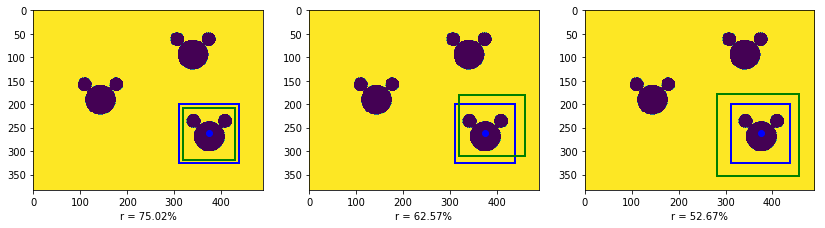

In [16]:
ref1 = ((264, 375), (110,110))
ref2 = ((245, 390), (130,140))
ref3 = ((265, 370), (175,175))

plt.gcf().set_size_inches(14,6)

plt.subplot(1,3,1)
plt.imshow(toy)
plot_bounding_box(p1)
plot_bounding_box(ref1[0],ref1[1], 'g', hide_center = True)
plt.xlabel("r = {:.2f}%".format(100*detection_quality(ref1,(p1,toy_filter.shape))))

plt.subplot(1,3,2)
plt.imshow(toy)
plot_bounding_box(p1)
plot_bounding_box(ref2[0],ref2[1], 'g', hide_center = True)
plt.xlabel("r = {:.2f}%".format(100*detection_quality(ref2,(p1,toy_filter.shape))))

plt.subplot(1,3,3)
plt.imshow(toy)
plot_bounding_box(p1)
plot_bounding_box(ref3[0],ref3[1], 'g', hide_center = True)
plt.xlabel("r = {:.2f}%".format(100*detection_quality(ref3,(p1,toy_filter.shape))));

$\textbf{3.3 Car Detection [6 pts]}$

Now that we have created an algorithm for matching templates and a function to determine the quality of the match, it is time to try some more realistic images. The file, cartemplate.jpg , will be the filter to convolve on each of the other car images $\textbf{(car1.jpg, car2.jpg, car3.jpg)}$. Each image will have an associated text files that contains two $x, y$ coordinates (one pair per line). These coordinates will be the ground truth bounding box for each image. For each car image, provide the
following:

1. A heat map image
2. The provided ground truth bounding box drawn on the original image (green)
3. The detected bounding box drawn on the original image (blue)
4. The overlap between the two bounding boxes drawn on the original image (purple)
5. The bounding box overlap percent r × 100%

Here are some helpful hints to increase the overlap percentage:
- Rescaling the car template to various sizes (for $\textbf{car1.jpg}$)
- Horizontally flipping the car template (for $\textbf{car2.jpg}$)
- A combination of the first two hints (for $\textbf{car3.jpg}$)
- Gaussian blurring might be useful in all cases

It may not be possible to achieve 50% overlap on all the images. Your analysis of the images will be worth as much as achieving a high overlap percentage.

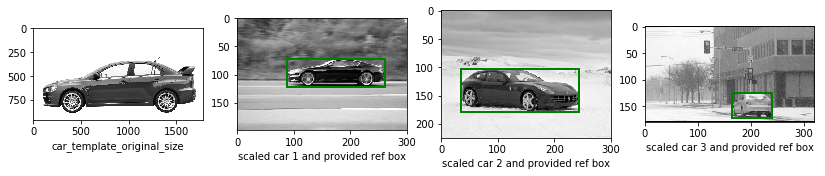

In [17]:
import matplotlib.transforms as transforms

def scaled_ref_bbox(left, bottom, right, top):
    bbox = transforms.Bbox.from_extents(left, bottom, right, top)
    transform = transforms.Affine2D().scale(0.5)
    return transforms.TransformedBbox(bbox, transform)

def plot_ref_box(bbox, isIntersection = False):
    x0, y0, width, height = bbox.bounds
    if isIntersection:
        color = 'purple'
    else:
        color = 'g'
    rectangle_patch = patches.Rectangle((x0,y0),width,height,linewidth=2,edgecolor=color,facecolor='none')
    plt.gca().add_patch(rectangle_patch)
    
car_template = imread('cartemplate.jpg')

car1_original_size = imread('car1.jpg')
car2_original_size = imread('car2.jpg')
car3_original_size = imread('car3.jpg')

car1_ref_bbox = scaled_ref_bbox(175, 145, 522, 245)
car2_ref_bbox = scaled_ref_bbox(69, 205, 488, 357)
car3_ref_bbox = scaled_ref_bbox(329, 251, 480, 345)

car1 = resize(car1_original_size, (np.array(car1_original_size.shape)/2).astype(int), mode='reflect')
car2 = resize(car2_original_size, (np.array(car2_original_size.shape)/2).astype(int), mode='reflect')
car3 = resize(car3_original_size, (np.array(car3_original_size.shape)/2).astype(int), mode='reflect')

plt.gcf().set_size_inches(14,4)

plt.subplot(1,4,1)
plt.imshow(car_template, cmap='gray')
plt.xlabel('car_template_original_size')

plt.subplot(1,4,2)
plt.imshow(car1,cmap='gray')
plot_ref_box(car1_ref_bbox)
plt.xlabel('scaled car 1 and provided ref box')

plt.subplot(1,4,3)
plt.imshow(car2,cmap='gray')
plot_ref_box(car2_ref_bbox)
plt.xlabel('scaled car 2 and provided ref box')

plt.subplot(1,4,4)
plt.imshow(car3,cmap='gray')
plot_ref_box(car3_ref_bbox)
plt.xlabel('scaled car 3 and provided ref box');

In [18]:
car1_t = car1 - np.mean(car1)
car1_template = resize(car_template[250:,:], (50,175), mode='reflect')
car1_template_t = car1_template - np.mean(car1_template)
car1_convolve = sp.ndimage.filters.convolve(car1_t,np.rot90(car1_template_t,2))

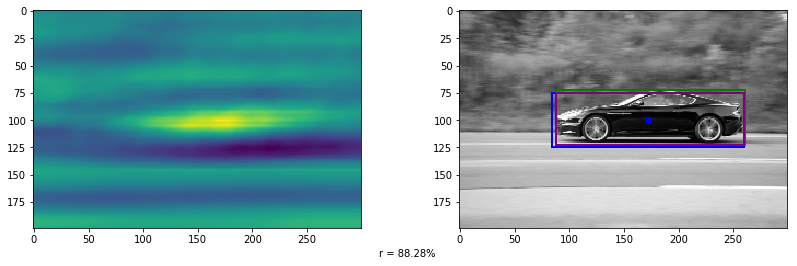

In [19]:
plt.gcf().set_size_inches(14,4)
plt.subplot(1,2,1)
plt.imshow(car1_convolve, cmap='jet')
plt.subplot(1,2,2)
car1_p = np.unravel_index(np.argsort(car1_convolve, axis=None)[-1], car1_convolve.shape)
plt.imshow(car1,cmap='gray')
plot_bounding_box(car1_p, sizeref=car1_template.shape)
plot_ref_box(car1_ref_bbox)
r1, car1_inter = detection_quality((car1_p, car1_template.shape), true_coordinates = car1_ref_bbox.bounds, receiveIntersection = True)
plt.xlabel("r = {:.2f}%".format(r1*100), x=-0.16)
plot_ref_box(car1_inter, isIntersection = True)

A very high accuracy is achieved because the **comparative intensity** of the car in the photo and its background closely matches the one in the reference photo. The **shape** of the car and the **orientation** both help achieve an easy close to 90% match.

In [20]:
car2_t = car2 - np.mean(car2)
car2_template = np.fliplr(resize(car_template[250:-50,:], (75,210), mode='reflect'))
car2_template_t = car2_template - np.mean(car2_template)
car2_convolve = sp.ndimage.filters.convolve(car2_t,np.rot90(car2_template_t,2))

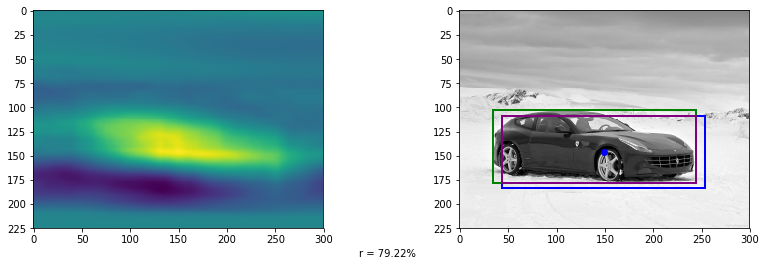

In [21]:
plt.gcf().set_size_inches(14,4)
plt.subplot(1,2,1)
plt.imshow(car2_convolve, cmap='jet')
plt.subplot(1,2,2)
car2_p = np.unravel_index(np.argsort(car2_convolve, axis=None)[-1], car2_convolve.shape)
plt.imshow(car2,cmap='gray')
plot_bounding_box(car2_p, sizeref=car2_template.shape)
plot_ref_box(car2_ref_bbox)
r2, car2_inter = detection_quality((car2_p, car2_template.shape), true_coordinates = car2_ref_bbox.bounds, receiveIntersection = True)
plt.xlabel("r = {:.2f}%".format(r2*100), x=-0.25)
plot_ref_box(car2_inter, isIntersection = True)

Although the vehicle in the photo does not share as much similarities with the previous instance, but the **intensity difference** of the car and the background clearly separates it out from the surroundings. It is obvious that the orientation of the car does not match that of the filter but we can flip the filter to match the car better in order to achieve a better result especially to carefully match the **shape**. In the end a close to 80% accuracy is achieved which is very satisfactory.

In [22]:
car3_g = cv2.GaussianBlur(car3,(5,5),0)
car3_t = car3_g - np.mean(car3_g)
car3_template = resize(car_template, (50,75), mode='reflect')[7:,:]
car3_template_t = car3_template - np.mean(car3_template)
car3_convolve = sp.ndimage.filters.convolve(car3_t,np.rot90(car3_template_t,2))

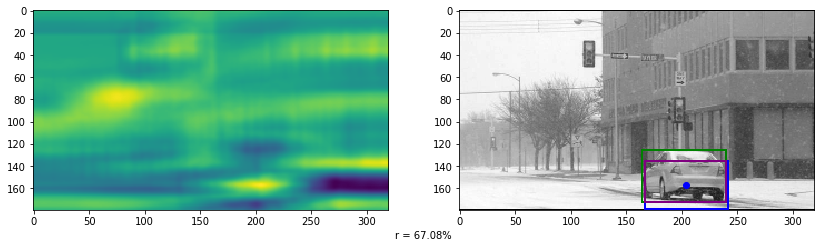

In [23]:
plt.gcf().set_size_inches(14,4)
plt.subplot(1,2,1)
plt.imshow(car3_convolve, cmap='jet')
plt.subplot(1,2,2)
car3_p = np.unravel_index(np.argsort(car3_convolve, axis=None)[-1], car3_convolve.shape)
plt.imshow(car3,cmap='gray')
plot_bounding_box(car3_p, sizeref=car3_template.shape)
plot_ref_box(car3_ref_bbox)
r3, car3_inter = detection_quality((car3_p, car3_template.shape), true_coordinates = car3_ref_bbox.bounds, receiveIntersection = True)
plt.xlabel("r = {:.2f}%".format(r3*100), x=-0.1)
plot_ref_box(car3_inter, isIntersection = True)

This object recognition task is very challenging because of the **noisy background** and the mismatch of intensity and shape of the car comparing to the object reference. However, with careful filter transformation, a 67% match is achieved. Note that the middle left area shows a second highlight region because the **tree** closely matched the shape of the car roof and the intensity levels in the reference photo. The detection is not easily achieved without filter image manipulations.